# Minifig Generation

In this project, I'll define and train a DCGAN on a dataset of Lego minifigures. The goal is to get a generator network to generate *new* images of minifigs that look as realistic as possible!

### Get the Data

I used images scraped from [brinklink.com](https://www.bricklink.com) and thus will not be sharing that.

### Pre-processed Data

The minifig photos have been manually filtered, removing low quality photos, and those containing multiple figures. Each photo has then been scaled to 256x256, padding the images when necessary, as most didn't have enough space around the figure to be cropped to a square shape.

In [37]:
# can comment out after executing
# !unzip minifigs.zip

In [38]:
data_dir = 'minifigs/'

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
#import helper

%matplotlib inline

In [39]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [40]:
def get_dataloader(batch_size, image_size, data_dir='minifigs/'):

    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.ToTensor()])
    
    dataset = datasets.ImageFolder(data_dir, transform)
    dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    
    return dataloader


## DataLoader

In [41]:
# Define function hyperparameters
batch_size = 20
img_size = 127

minifig_train_loader = get_dataloader(batch_size, img_size)

View sample images!

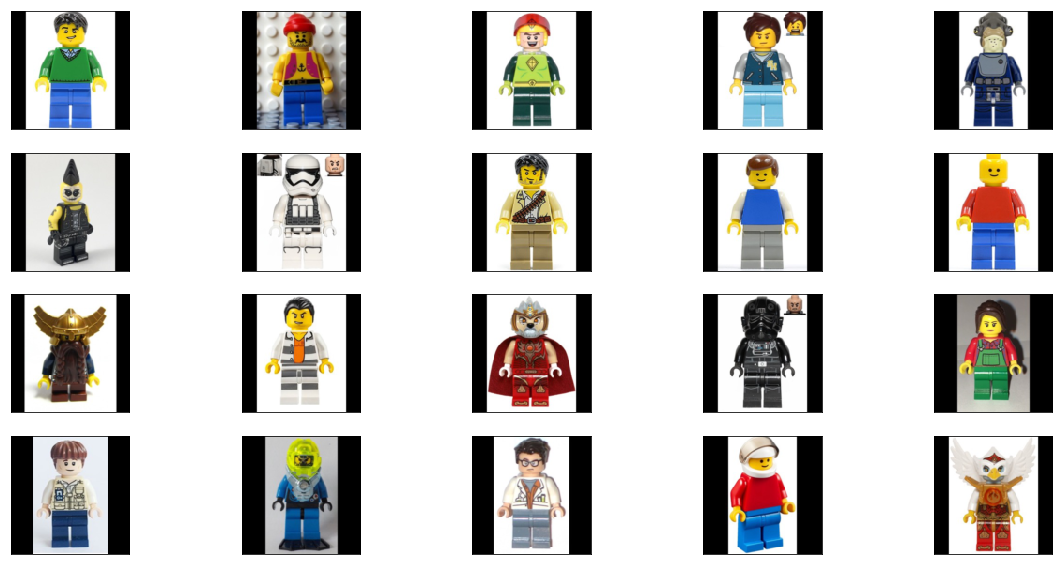

In [42]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# obtain one batch of training images
dataiter = iter(minifig_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 10))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(4, plot_size/4, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [43]:
def scale(x, feature_range=(-1, 1)):
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    
    return x

In [44]:
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-1.)
Max:  tensor(1.)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

In [45]:
import torch.nn as nn
import torch.nn.functional as F

In [46]:
def conv(in_ch, out_ch, kernel_size=5, stride=2, padding=1, batch_norm=True):
    
    layers = []
    conv_layer = nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding, bias=False)
    layers.append(conv_layer)
    
    layers.append(nn.LeakyReLU(0.2, inplace=True))
    layers.append(nn.Dropout2d(0.25))
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_ch))
        
    return nn.Sequential(*layers)

In [47]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        # 127x in
        self.conv1 = conv(3, conv_dim, batch_norm=False)
        # 63x in
        self.conv2 = conv(conv_dim, conv_dim*2)
        # 31x in
        self.conv3 = conv(conv_dim*2, conv_dim*4)
        # 15x in
        self.conv4 = conv(conv_dim*4, conv_dim*8)
        # 7x in
#         self.conv5 = conv(conv_dim*8, conv_dim*16)
        # 4x out
        
        self.fc = nn.Linear(conv_dim*7*7*8, 1)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        
        out = out.view(-1, self.conv_dim*7*7*8)
        
        out = self.fc(out)
        
        return out

## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data. This should be mostly transpose convolutional layers with normalization applied to the outputs.

In [48]:
def deconv(in_ch, out_ch, kernel_size=5, stride=2, padding=1, batch_norm=True, relu=True):
    layers = []
    
    deconv_layer = nn.ConvTranspose2d(in_ch, out_ch, kernel_size, stride, padding, bias=False)
    layers.append(deconv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_ch))
    
    if relu:
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        
    return nn.Sequential(*layers)

In [49]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        self.fc = nn.Linear(z_size, conv_dim*7*7*16)
        # 7x in
        self.deconv1 = deconv(conv_dim*16, conv_dim*8)
        # 15x in
        self.deconv2 = deconv(conv_dim*8, conv_dim*4)
        # 31x in
        self.deconv3 = deconv(conv_dim*4, conv_dim*2)
        # 63x in
        self.deconv4 = deconv(conv_dim*2, conv_dim)
        # 127x in
        self.deconv5 = deconv(conv_dim, 3, stride=1, kernel_size=3, padding=1, batch_norm=False, relu=False)
        

    def forward(self, x):
        # define feedforward behavior
        out = self.fc(x)
        out = out.view(-1, self.conv_dim * 16, 7, 7)
        
        out = self.deconv1(out)
        out = self.deconv2(out)
        out = self.deconv3(out)
        out = self.deconv4(out)
        out = F.tanh(self.deconv5(out))
        
        return out

## Initialize the weights of networks

In [50]:
def weights_init_normal(m):
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    mean = 0
    std_dev = 0.02
    
    if (classname.find('Linear') != -1 or classname.find('Conv') != -1) and hasattr(m, 'weight'):
        m.weight.data.normal_(mean, std_dev)    

## Build complete network

In [51]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


In [52]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Dropout2d(p=0.25)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Dropout2d(p=0.25)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Dropout2d(p=0.25)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Dropout2d(p=0.25)
    (3): BatchNorm2d(512, eps=1e-05, momentum=0.1

### Training on GPU

In [53]:
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

In [54]:
def real_loss(D_out):
    batch_size = D_out.size(0)
    # TODO: check need for *0.9
    labels = torch.ones(batch_size) # real = 1
    
    if (train_on_gpu):
        labels = labels.cuda()
    
    criterion = nn.BCEWithLogitsLoss()
    
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake = 0
    
    if (train_on_gpu):
        labels = labels.cuda()
    
    criterion = nn.BCEWithLogitsLoss()
    
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

In [55]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G
lr = 0.0002
b1 = 0.3 # test 0.3 - 0.5
b2 = 0.999

d_optimizer = optim.Adam(D.parameters(), lr, [b1, b2])
g_optimizer = optim.Adam(G.parameters(), lr, [b1, b2])

In [56]:
from workspace_utils import active_session

def train(D, G, n_epochs, print_every=50):
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=8
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    with active_session():
        # epoch training loop
        for epoch in range(n_epochs):

            # batch training loop
            for batch_i, (real_images, _) in enumerate(minifig_train_loader):

                batch_size = real_images.size(0)
                real_images = scale(real_images)

                # ===============================================
                #         YOUR CODE HERE: TRAIN THE NETWORKS
                # ===============================================

                # 1. Train the discriminator on real and fake images
                d_optimizer.zero_grad()

                # loss on real images
                if train_on_gpu:
                    real_images = real_images.cuda()

                D_real = D(real_images)
                d_real_loss = real_loss(D_real)

                # loss on fake images
                z = np.random.uniform(-1, 1, size=(batch_size, z_size))
                z = torch.from_numpy(z).float()

                if train_on_gpu:
                    z = z.cuda()
                fake_images = G(z)

                D_fake = D(fake_images)
                d_fake_loss = fake_loss(D_fake)

                # total D loss + backprop
                d_loss = (d_real_loss + d_fake_loss)/2
                d_loss.backward()
                d_optimizer.step()


                # 2. Train the generator with an adversarial loss
                g_optimizer.zero_grad()
                
                z = np.random.uniform(-1, 1, size=(batch_size, z_size))
                z = torch.from_numpy(z).float()

                if train_on_gpu:
                    z = z.cuda()
                fake_images = G(z)

                D_fake = D(fake_images)

                # G loss + backprop
                g_loss = real_loss(D_fake)
                g_loss.backward()
                g_optimizer.step()


                # ===============================================
                #              END OF YOUR CODE
                # ===============================================

                # Print some loss stats
                if batch_i % print_every == 0:
                    # append discriminator loss and generator loss
                    losses.append((d_loss.item(), g_loss.item()))
                    # print discriminator and generator loss
                    print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                            epoch+1, n_epochs, d_loss.item(), g_loss.item()))


            ## AFTER EACH EPOCH##    
            # this code assumes your generator is named G, feel free to change the name
            # generate and save sample, fake images
            G.eval() # for generating samples
            samples_z = G(fixed_z)
            samples.append(samples_z)
            G.train() # back to training mode

        # Save training generator samples
        with open('minifig_samples.pkl', 'wb') as f:
            pkl.dump(samples, f)

        # finally return losses
        return losses

In [57]:
# set number of epochs 
n_epochs = 50

# call training function
losses = train(D, G, n_epochs=n_epochs, print_every=500)

Epoch [    1/   50] | d_loss: 0.8730 | g_loss: 2.2032
Epoch [    2/   50] | d_loss: 0.1339 | g_loss: 4.5052
Epoch [    3/   50] | d_loss: 0.2455 | g_loss: 1.7432
Epoch [    4/   50] | d_loss: 0.5493 | g_loss: 1.4847
Epoch [    5/   50] | d_loss: 0.4210 | g_loss: 2.9296
Epoch [    6/   50] | d_loss: 0.6935 | g_loss: 2.5183
Epoch [    7/   50] | d_loss: 0.4358 | g_loss: 2.4727
Epoch [    8/   50] | d_loss: 0.5924 | g_loss: 1.5414
Epoch [    9/   50] | d_loss: 0.4671 | g_loss: 1.0344
Epoch [   10/   50] | d_loss: 0.4188 | g_loss: 1.9688
Epoch [   11/   50] | d_loss: 0.4766 | g_loss: 2.0437
Epoch [   12/   50] | d_loss: 0.3641 | g_loss: 1.5114
Epoch [   13/   50] | d_loss: 0.4528 | g_loss: 1.0160
Epoch [   14/   50] | d_loss: 0.3608 | g_loss: 1.5168
Epoch [   15/   50] | d_loss: 0.6310 | g_loss: 3.5132
Epoch [   16/   50] | d_loss: 0.5942 | g_loss: 3.5577
Epoch [   17/   50] | d_loss: 0.4617 | g_loss: 2.6648
Epoch [   18/   50] | d_loss: 0.3517 | g_loss: 2.1037
Epoch [   19/   50] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

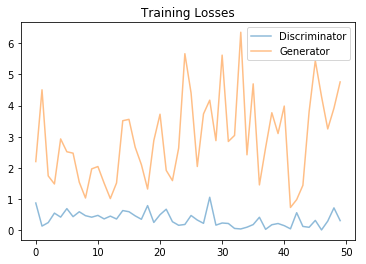

In [58]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator.

In [63]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(20,5), nrows=2, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((127,127,3)))

In [64]:
# Load samples from generator, taken while training
with open('minifig_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

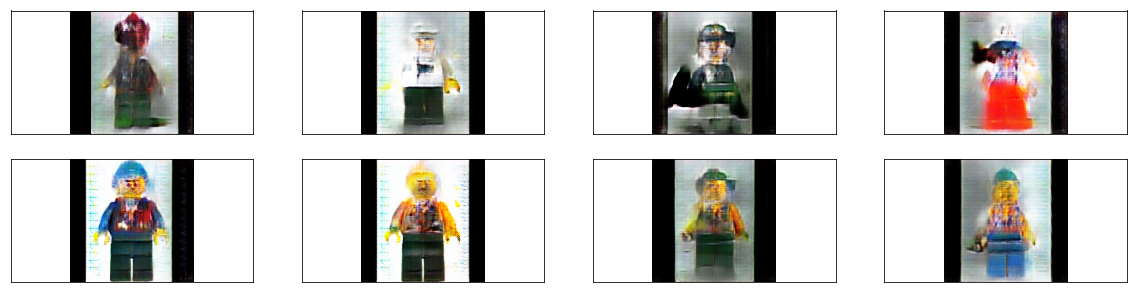

In [65]:
_ = view_samples(-1, samples)

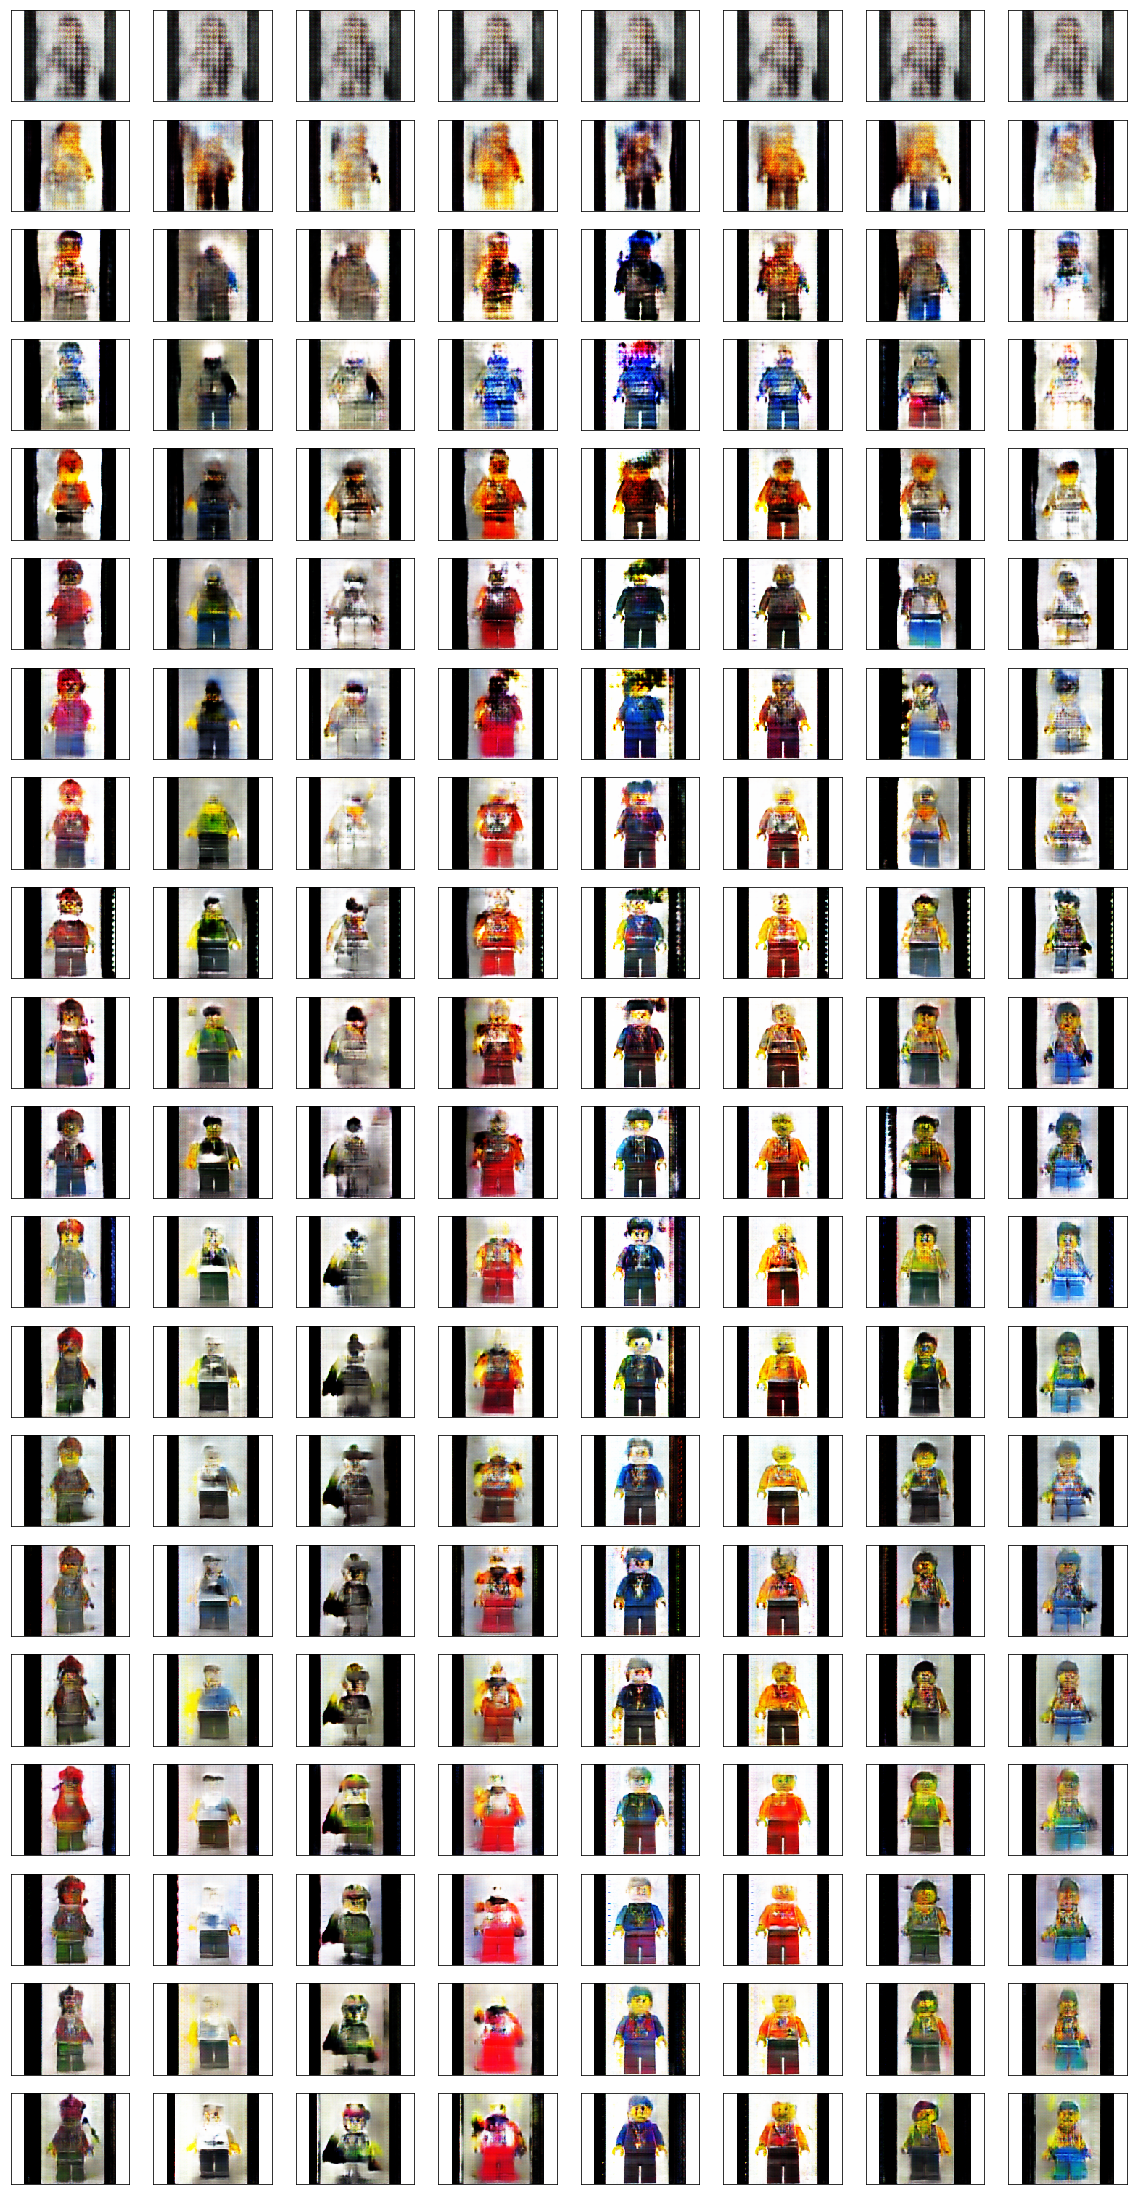

In [62]:
rows = 20 # split epochs into 10, so 100/10 = every 10 epochs
cols = 8
fig, axes = plt.subplots(figsize=(20,40), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.imshow(img.reshape((127,127,3)))
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)